In [2]:
from keras.layers import Input,Dense,Flatten,Concatenate
from keras.models import Model

# getting the pretrained model 
from keras.applications.vgg16 import VGG16,preprocess_input  #xception 

from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras import utils
from keras.optimizers import Adam

from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy,mse

from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from glob import glob

from skimage.transform import resize 

from imageio import imread

In [4]:
def custom_loss(y_true,y_pred):
  mse_1=mse(y_true[:,:4],y_pred[:,:4]) #regression
  cce=categorical_crossentropy(y_true[:,4:7],y_pred[:,4:7]) #classification
  bce2= binary_crossentropy(y_true[:,-1],y_pred[:,-1]) # existance

  return mse_1*y_true[:,-1] + cce*y_true[:,-1] + 0.5*bce2

In [5]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [6]:
bg_imgs=[]
bg_list=glob('backgrounds/*.jp*g')
for i in bg_list:
  bg=np.array(imread(i))
  bg_imgs.append(bg)

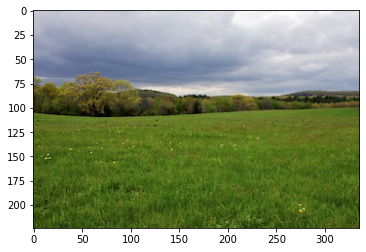

In [8]:
plt.imshow(bg_imgs[6])

In [11]:
ch=imread('charmander-tight (1).png')
bb=imread('bulbasaur-tight.png')
sq=imread('squirtle-tight.png')

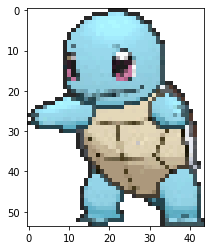

In [12]:
plt.imshow(sq)

In [13]:
poke_dim=200
ch=np.array(ch)
bb=np.array(bb)
sq=np.array(sq)

ch_h,ch_w,ch_c=ch.shape
bb_h,bb_w,bb_c=bb.shape
sq_h,sq_w,sq_c=sq.shape

poke_data=[
    [ch,ch_h,ch_w,ch_c],
    [bb,bb_h,bb_w,bb_c],
    [sq,sq_h,sq_w,sq_c]
]  # random index , use 

class_names=['charmander','bulbasaur','squirtle']

In [17]:
poke_data[np.random.randint(3)][0].shape

(56, 44, 4)

In [18]:


def image_generator(batch_size=64):
  while True:
    for _ in range(50):#50 batches per epoch 
      X=np.zeros((batch_size,poke_dim,poke_dim,3))
      Y=np.zeros((batch_size,8))

      for i in range(batch_size):
        #select random bg
        bg_idx=np.random.choice(len(bg_imgs))
        bg=bg_imgs[bg_idx]
        bg_h,bg_w,_=bg.shape

        rnd_h=np.random.randint(bg_h-poke_dim)
        rnd_w=np.random.randint(bg_w-poke_dim)

        X[i]=bg[rnd_h:rnd_h+poke_dim,rnd_w:rnd_w+poke_dim].copy() #bg slice

        appear=np.random.random()<0.75 
        #np.random.choice([0,1]) 
        if appear:
          pk_idx=np.random.randint(3)
          ch,ch_h,ch_w,ch_channels=poke_data[pk_idx]


          #random scaling 
          
          scale=0.5+np.random.random() #0.5,1.5
          
          new_h=int(ch_h*scale)
          new_w=int(ch_w*scale)

          obj=resize(ch,(new_h,new_w),preserve_range=True).astype(np.uint8)

                  
          #maybe flip 
          if np.random.random()<0.5:
            obj = np.fliplr(obj)


          row0=np.random.randint(poke_dim-new_h)
          col0=np.random.randint(poke_dim-new_w)
          row1=row0+new_h
          col1=col0+new_w


          mask=obj[:,:,3]==0
          bg_slice=X[i,row0:row1,col0:col1,:]
          bg_slice=np.expand_dims(mask,-1)*bg_slice
          bg_slice=bg_slice+obj[:,:,:3]

          X[i,row0:row1,col0:col1,:]=bg_slice

          Y[i,0]=row0/poke_dim
          Y[i,1]=col0/poke_dim
          Y[i,2]=(row1-row0)/poke_dim
          Y[i,3]=(col1-col0)/poke_dim
          
          Y[i,4+pk_idx]=1

        Y[i,7]=appear
      
      yield X/255.,Y



In [19]:
for x,y in image_generator():
  xx,yy=x,y 
  break

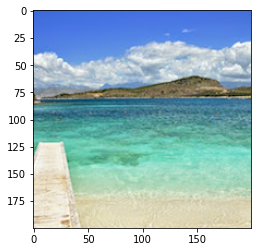

In [25]:
plt.imshow(xx[0])

In [26]:
yy[0]

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
vgg=VGG16(input_shape=[poke_dim,poke_dim,3],weights='imagenet',include_top=False)
x=Flatten()(vgg.output) #flattend output of feature extractor 

x1=Dense(4,activation='sigmoid')(x) #location

x2=Dense(3,activation='softmax')(x) #classes

x3=Dense(1,activation='sigmoid')(x) #object appeared 

x=Concatenate()([x1,x2,x3])

model=Model(vgg.input,x)
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                             

In [28]:
model.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.0001))

In [29]:
hist=model.fit(image_generator(),steps_per_epoch=50,epochs=5,verbose=1)

Epoch 1/5
50/50 [==============================] - 55s 720ms/step - loss: 0.3649
Epoch 2/5
50/50 [==============================] - 37s 741ms/step - loss: 0.0153
Epoch 3/5
50/50 [==============================] - 37s 733ms/step - loss: 0.0049
Epoch 4/5
50/50 [==============================] - 37s 735ms/step - loss: 0.0028
Epoch 5/5
50/50 [==============================] - 37s 736ms/step - loss: 0.0024


In [30]:
def make_pred():
  #select random bg
  bg_idx=np.random.choice(len(bg_imgs))
  bg=bg_imgs[bg_idx]
  bg_h,bg_w,_=bg.shape

  rnd_h=np.random.randint(bg_h-poke_dim)
  rnd_w=np.random.randint(bg_w-poke_dim)

  x=bg[rnd_h:rnd_h+poke_dim,rnd_w:rnd_w+poke_dim].copy() #bg slice

  appear=np.random.random()<0.75
  if appear:
    pk_idx=np.random.randint(3)
    ch,ch_h,ch_w,_=poke_data[pk_idx]

    #random scaling   
    scale=0.5+np.random.random() #0.5,1.5
    new_h=int(ch_h*scale)
    new_w=int(ch_w*scale)
    obj=resize(ch,(new_h,new_w),preserve_range=True).astype(np.uint8)      
    #maybe flip 
    if np.random.random()<0.5:
      obj = np.fliplr(obj)

    row0=np.random.randint(poke_dim-new_h)
    col0=np.random.randint(poke_dim-new_w)
    row1=row0+new_h
    col1=col0+new_w

    mask=obj[:,:,3]==0
    bg_slice=x[row0:row1,col0:col1,:]
    bg_slice=np.expand_dims(mask,-1)*bg_slice
    bg_slice=bg_slice+obj[:,:,:3]

    x[row0:row1,col0:col1,:]=bg_slice

    print(row0,col0,row1,col1)

  X=np.expand_dims(x,0)/255.
  p=model.predict(X)[0]

  fig,ax=plt.subplots(1)
  ax.imshow(x.astype(np.uint8))

  if p[7]>0.5:
    rect=Rectangle(
        (p[1]*poke_dim,p[0]*poke_dim),
        p[3]*poke_dim,p[2]*poke_dim,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    oc=np.argmax([p[4:7]])
    print(class_names[oc])
  else:
    print('No Object')
  plt.show()



5 77 55 121
1/1 [==============================] - 0s 20ms/step
bulbasaur


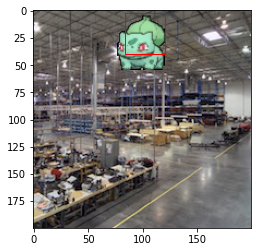

In [40]:
make_pred()